<a href="https://colab.research.google.com/github/vikram0230/Mustache-Detection/blob/main/Mustache%20Detection%20with%20OpenCV/mustache_detection_opencv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  **Importing Data** 🌐

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import zipfile
import os
from keras.layers import Dense,Flatten,MaxPool2D,Conv2D,Dropout,GlobalAveragePooling2D
from keras.losses import binary_crossentropy,categorical_crossentropy
from keras.models import Model,Sequential
from keras.callbacks import EarlyStopping
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from google.colab import files
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

# upload kaggle API key
files.upload()

In [138]:
# Upload haarcascade_frontalface_default
files.upload()

face_classifier = cv2.CascadeClassifier('/content/haarcascade_frontalface_default.xml')

Saving haarcascade_frontalface_default.xml to haarcascade_frontalface_default (1).xml


In [139]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d jessicali9530/celeba-dataset

In [ ]:
!mkdir train

In [ ]:
!mkdir refined

In [ ]:
!mkdir gray

In [ ]:
!unzip celeba-dataset.zip -d train

In [145]:
BASE_PATH = '/content/train/img_align_celeba/img_align_celeba/'

In [146]:
REFINED_IMAGE_PATH = '/content/refined/'

In [147]:
REFINED_GRAY_PATH = '/content/gray/'

In [148]:
attributes = pd.read_csv('/content/train/list_attr_celeba.csv',index_col='image_id')

In [149]:
attributes.head()

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
image_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,1,-1,1,-1,-1,1,-1,-1,1,-1,-1,-1,1,1,-1,1,-1,1,-1,-1,1
000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1,-1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1
000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1
000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,-1,-1,-1,-1,1,-1,1,-1,1,1,-1,1
000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1


# **Data Analysis And Validation** 🤓 

In [150]:
# Dataset Correction

attributes.loc['065618.jpg']['Mustache'] = -1
attributes.loc['119681.jpg']['Mustache'] = -1
attributes.loc['133479.jpg']['Male'] = 1
attributes.drop(index='009561.jpg',axis=0,inplace=True)

In [151]:
# Male Count

attributes.Male.value_counts()

-1    118164
 1     84434
Name: Male, dtype: int64

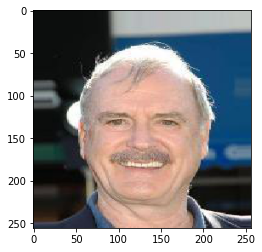

In [152]:
img = load_img(BASE_PATH+'059445.jpg',target_size=(256,256)) # 116878
plt.imshow(img)

In [153]:
# Male with mustache

male = attributes[attributes.Male == 1]
male_with_mustache = male[male.Mustache == 1]


# Male without mustache

male_without_mustache = male[male.Mustache == -1]
male_without_mustache_duplicate = male_without_mustache[:8415]

In [154]:
male_with_mustache.shape,male_without_mustache_duplicate.shape

((8415, 40), (8415, 40))

In [155]:
# Counting detected faces

def detectedFaces(img):
  image = cv2.imread(BASE_PATH + img.name)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  faces = face_classifier.detectMultiScale(gray, 1.05, 5)

  if faces is ():
    return -1
  if len(faces) == 1:
    for (x,y,w,h) in faces:
      cropped_img = image[y:y+h,x:x+w]
      cv2.imwrite(REFINED_IMAGE_PATH + img.name,cropped_img)
      cropped_gray = gray[y:y+h,x:x+w]
      cv2.imwrite(REFINED_GRAY_PATH + img.name,cropped_gray)

  return len(faces)

In [ ]:
male_with_mustache['DetectedFace'] = male_with_mustache.apply(detectedFaces, axis = 1)
male_without_mustache_duplicate['DetectedFace'] = male_without_mustache_duplicate.apply(detectedFaces, axis = 1)

In [157]:
male_with_mustache.DetectedFace.value_counts()

 1    7630
 2     393
-1     382
 3      10
Name: DetectedFace, dtype: int64

In [158]:
male_without_mustache_duplicate.DetectedFace.value_counts()

 1    7681
 2     372
-1     353
 3       8
 5       1
Name: DetectedFace, dtype: int64

In [ ]:
# Remove undetected, multiple face images
male_with_mustache.drop(male_with_mustache[male_with_mustache['DetectedFace'] < 0].index, inplace = True) 
male_without_mustache_duplicate.drop(male_without_mustache_duplicate[male_without_mustache_duplicate['DetectedFace'] < 0].index, inplace = True) 
male_with_mustache.drop(male_with_mustache[male_with_mustache['DetectedFace'] > 1].index, inplace = True) 
male_without_mustache_duplicate.drop(male_without_mustache_duplicate[male_without_mustache_duplicate['DetectedFace'] > 1].index, inplace = True) 

In [160]:
mwm = male_with_mustache.iloc[:7600]
mwom = male_without_mustache_duplicate.iloc[:7600]

In [161]:
mustache_data = pd.DataFrame(mwm)
mustache_data = mustache_data.append(mwom)
mustache_data = mustache_data[['Mustache','DetectedFace']]

In [162]:
# Data Shuffling
mustache_data = pd.DataFrame(mustache_data.sample(frac=1))

In [163]:
# Replacing binary to string
mustache_data.Mustache.replace(to_replace=1,value='Yes',inplace=True)
mustache_data.Mustache.replace(to_replace=-1,value='No',inplace=True)

# Adding refined image path to dataframe
mustache_data['image_path'] = mustache_data.apply(lambda row: REFINED_IMAGE_PATH + row.name,axis=1)

# Adding gray image path to dataframe
# mustache_data['image_path'] = mustache_data.apply(lambda row: REFINED_GRAY_PATH + row.name,axis=1)

In [164]:
mustache_data.head()

,Mustache,DetectedFace,image_path
image_id,,,
062917.jpg,Yes,1,/content/refined/062917.jpg
131665.jpg,Yes,1,/content/refined/131665.jpg
174938.jpg,Yes,1,/content/refined/174938.jpg
010959.jpg,No,1,/content/refined/010959.jpg
017512.jpg,No,1,/content/refined/017512.jpg


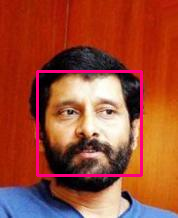

In [165]:
image = cv2.imread(BASE_PATH+'016557.jpg') # 016557 #122275
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

faces = face_classifier.detectMultiScale(gray, 1.01, 5)

if faces is ():
    print("No faces found")

for (x,y,w,h) in faces:
    cv2.rectangle(image, (x,y), (x+w,y+h), (127,0,255), 2)
    cv2_imshow(image)
    cv2.waitKey(0)

In [166]:
image.shape

(218, 178, 3)

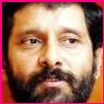

True

In [167]:
cropped_img = image[y:y+h,x:x+w]
cv2_imshow(cropped_img)
cv2.imwrite(REFINED_IMAGE_PATH + '016557.jpg',cropped_img)

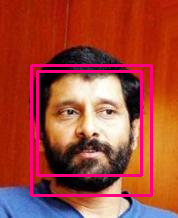

In [168]:
# increased dimensions
for (x,y,w,h) in faces:
    rt = int(0.1*w+x+w)
    lb = int(0.2*h+y+h)
    x = int(x-0.05*w)
    y = int(y-0.05*h)
    cv2.rectangle(image, (x,y), (rt,lb), (127,0,255), 2)
    cv2_imshow(image)
    cv2.waitKey(0)

# **Sample images**

In [169]:
def concatHoriz1(img):
  img2 = cv2.imread(REFINED_IMAGE_PATH + img.name) 
  img2 = cv2.resize(img2, (128, 128))
  global images1
  images1 = np.concatenate((images1, img2), axis=1)

def concatHoriz2(img):
  img2 = cv2.imread(REFINED_IMAGE_PATH + img.name) 
  img2 = cv2.resize(img2, (128, 128))
  global images2
  images2 = np.concatenate((images2, img2), axis=1)

def concatHoriz3(img):
  img2 = cv2.imread(REFINED_IMAGE_PATH + img.name) 
  img2 = cv2.resize(img2, (128, 128))
  global images3
  images3 = np.concatenate((images3, img2), axis=1)

In [170]:
global images1,images2,images3

images1 = cv2.imread(REFINED_IMAGE_PATH + mustache_data.index[0])
images1 = cv2.resize(images1, (128, 128))
_ = mustache_data[1:15].apply(lambda img: concatHoriz1(img), axis=1)

images2 = cv2.imread(REFINED_IMAGE_PATH + mustache_data.index[15])
images2 = cv2.resize(images2, (128, 128))
_ = mustache_data[16:30].apply(lambda img: concatHoriz2(img), axis=1)

images3 = cv2.imread(REFINED_IMAGE_PATH + mustache_data.index[30])
images3 = cv2.resize(images3, (128, 128))
_ = mustache_data[31:45].apply(lambda img: concatHoriz3(img), axis=1)

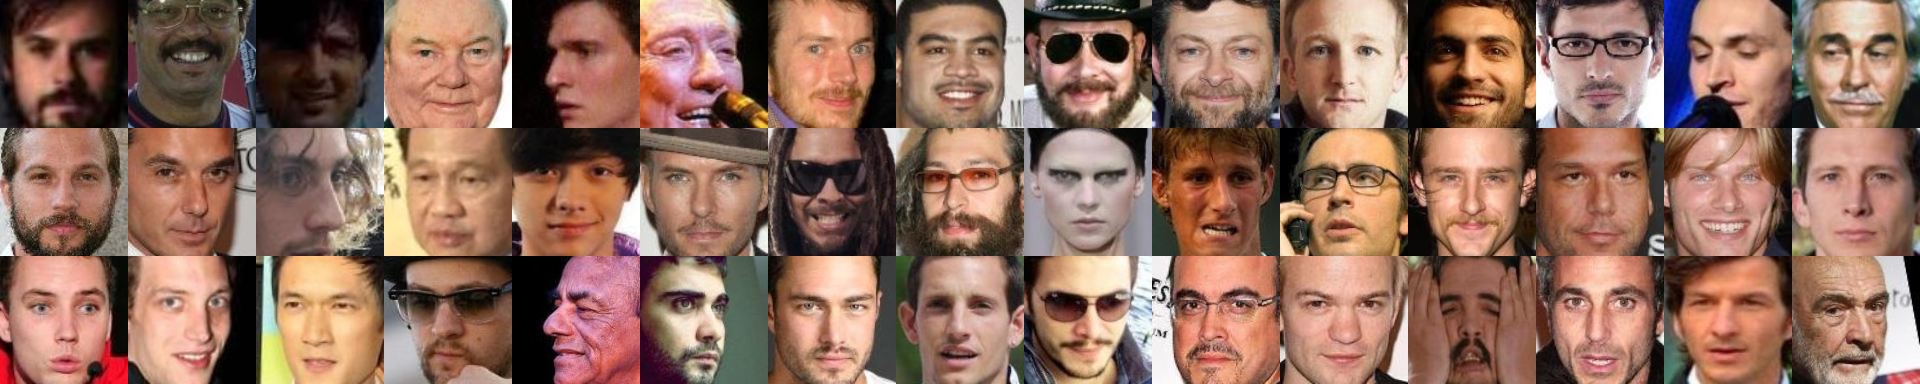

In [171]:
images = np.concatenate((images1, images2), axis=0)
images = np.concatenate((images, images3), axis=0)
cv2_imshow(images)

In [172]:
mustache_data.index[16]

'008617.jpg'

# **Multiple Faces Optimization**

In [ ]:
# multipleFaces = mustache_data.drop(mustache_data[mustache_data['DetectedFace'] < 2].index) 

# doubleFaces = multipleFaces.drop(multipleFaces[multipleFaces['DetectedFace'] > 2].index) 
# tripleFaces = multipleFaces.drop(multipleFaces[multipleFaces['DetectedFace'] < 3].index) 

# multipleFaces.loc['059445.jpg']


# image = cv2.imread(BASE_PATH + doubleFaces.index[1]) # 016557
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# print(doubleFaces.index[4])

# faces = face_classifier.detectMultiScale(gray, 1.01, 5)

# if faces is ():
#     print("No faces found")

# for (x,y,w,h) in faces:
#     print(faces)
#     cv2.rectangle(image, (x,y), (x+w,y+h), (127,0,255), 2)
#     cv2_imshow(image)
#     cv2.waitKey(0)

    
# dup = doubleFaces.sort_index(axis=0)

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     print(dup)

# **Image Generation**

In [194]:
train_data = mustache_data[:8000]
val_data = mustache_data[8000:11000]
test_data = mustache_data[11000:]

In [195]:
mustache_data.shape, train_data.shape, val_data.shape, test_data.shape

((15200, 3), (8000, 3), (3000, 3), (4200, 3))

In [196]:
train_datagen = ImageDataGenerator(
    rotation_range=40, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True, 
    rescale=1/255,
)

val_datagen = ImageDataGenerator(
    rescale=1/255
)

In [197]:
train_generator = train_datagen.flow_from_dataframe(train_data,x_col='image_path',y_col='Mustache',target_size=(256,256))
val_generator = val_datagen.flow_from_dataframe(val_data,x_col='image_path',y_col='Mustache',target_size=(256,256))

Found 8000 validated image filenames belonging to 2 classes.
Found 3000 validated image filenames belonging to 2 classes.


In [198]:
from keras.applications.inception_v3 import InceptionV3

In [199]:
inception = InceptionV3(include_top=False,input_shape=(256,256,3),classes=2)

# **Currently Training**

In [201]:
train_layer = inception.layers[52:]
for i in train_layer:
  i.trainable = True

earlyStopper = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)

keras.backend.clear_session()
x = GlobalAveragePooling2D()(inception.output)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(2, activation='softmax')(x)

model = Model(inception.inputs,x)

model.compile(optimizer=RMSprop(learning_rate=0.001), metrics=['accuracy'],loss='binary_crossentropy')

history = model.fit(train_generator, epochs=30, validation_data=val_generator, callbacks=[earlyStopper])

Epoch 1/30
250/250 [==============================] - 146s 547ms/step - loss: 0.8859 - accuracy: 0.4952 - val_loss: 7858.1514 - val_accuracy: 0.5050
Epoch 2/30
250/250 [==============================] - 135s 541ms/step - loss: 0.6952 - accuracy: 0.5235 - val_loss: 1.3225 - val_accuracy: 0.6183
Epoch 3/30
250/250 [==============================] - 137s 548ms/step - loss: 0.5146 - accuracy: 0.7574 - val_loss: 2.9157 - val_accuracy: 0.5417
Epoch 4/30
250/250 [==============================] - 139s 555ms/step - loss: 0.4335 - accuracy: 0.8160 - val_loss: 1.3967 - val_accuracy: 0.7470
Epoch 5/30
250/250 [==============================] - 136s 545ms/step - loss: 0.3905 - accuracy: 0.8431 - val_loss: 0.4738 - val_accuracy: 0.8613
Epoch 6/30
250/250 [==============================] - 135s 541ms/step - loss: 0.3701 - accuracy: 0.8481 - val_loss: 0.6376 - val_accuracy: 0.8660
Epoch 7/30
250/250 [==============================] - 136s 542ms/step - loss: 0.3671 - accuracy: 0.8446 - val_loss: 0.676

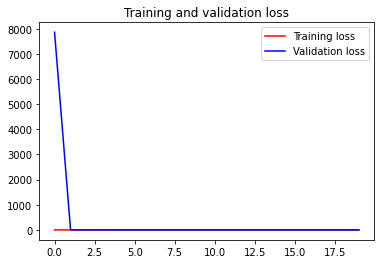

<Figure size 432x288 with 0 Axes>

In [202]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

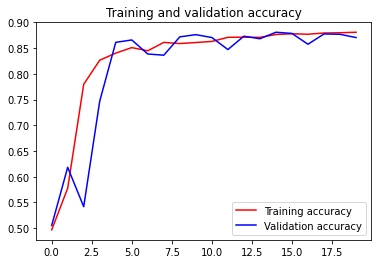

<Figure size 432x288 with 0 Axes>

In [203]:
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [204]:
model.evaluate_generator(val_generator)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.30753380060195923, 0.8809999823570251]

# **Conclusion**

In [205]:
model.save_weights('mustache_detection_inception.h5')

In [ ]:
files.download('mustache_detection_inception.h5')

In [94]:
# Sample Image Prediction

def predict_mustache(imagePath):
  image = cv2.imread(imagePath)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  faces = face_classifier.detectMultiScale(gray, 1.05, 5)

  # Condition: Works only when 1 face is detected
  if len(faces) == 1:
    for (x,y,w,h) in faces:
      cropped_img = image[y:y+h,x:x+w]
      cropped_img = cv2.resize(cropped_img, (256, 256)) 
      img_tensor = img_to_array(cropped_img)
      img_tensor = np.expand_dims(img_tensor, axis=0)
      img_tensor /= 255.
      prediction = model.predict(img_tensor)
      prediction_class = classes[np.argmax(prediction)]
      cv2_imshow(image)
      print(prediction_class)

In [95]:
from random import randint
from keras.preprocessing.image import load_img,img_to_array

In [96]:
classes = ['No Mustache Detected','Mustache Detected']

Expected: No
No Mustache Detected


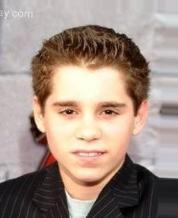

In [97]:
idx = randint(1,test_data.shape[0])
imageName = test_data.index[idx]
actual = test_data.loc[imageName]['Mustache']
print('Expected: {}'.format(actual))
imagePath = BASE_PATH + imageName
predict_mustache(imagePath)

Expected: Yes
Mustache Detected


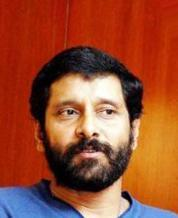

In [110]:
idx = randint(1,test_data.shape[0])
imageName = test_data.index[idx]
actual = test_data.loc[imageName]['Mustache']
print('Expected: {}'.format(actual))
imagePath = BASE_PATH + imageName
predict_mustache(imagePath)